In [1]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import sklearn


In [2]:
movie=pd.read_csv('movies.csv')

In [3]:
rating=pd.read_csv('ratings.csv')

In [4]:
print(rating.shape)
print(list(rating.columns))

(100836, 4)
['userId', 'movieId', 'rating', 'timestamp']


In [5]:
rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


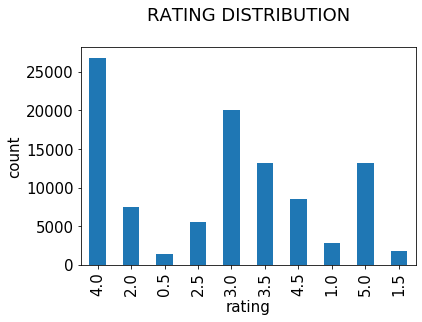

In [6]:
plt.rc("font",size=15)
rating.rating.value_counts(sort=False).plot(kind='bar')
plt.title('RATING DISTRIBUTION\n')
plt.xlabel('rating')
plt.ylabel('count')
plt.show()

In [7]:
print(movie.shape)
print(list(movie.columns))

(9742, 3)
['movieId', 'title', 'genres']


In [8]:
rating['rating'].min() 

0.5

In [9]:
rating['rating'].max() 

5.0

In [10]:
combine_movie_rating=pd.merge(rating,movie, on='movieId')

In [11]:
columns=['genres']
combine_movie_rating=combine_movie_rating.drop(columns,axis=1)

In [12]:
combine_movie_rating.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [13]:
most_rated = combine_movie_rating.groupby('title').size().sort_values(ascending=False)[:25]
most_rated.head(25)

title
Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
Star Wars: Episode IV - A New Hope (1977)                                         251
Jurassic Park (1993)                                                              238
Braveheart (1995)                                                                 237
Terminator 2: Judgment Day (1991)                                                 224
Schindler's List (1993)                                                           220
Fight Club (1999)                                                                 218
Toy Story (1995)                                

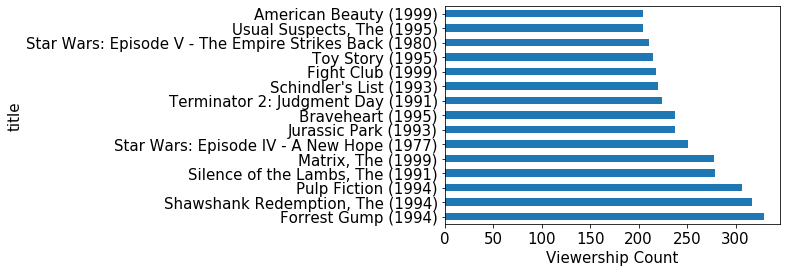

In [33]:
#Top 25 movies by viewership rating

res = combine_movie_rating.groupby("title").size().sort_values(ascending=False)[:15]
plt.ylabel("Title")
plt.xlabel("Viewership Count")
res.plot(kind="barh")


In [15]:
combine_movie_rating=combine_movie_rating.dropna(axis=0, subset=['title'])

In [16]:
movie_ratingCount=(combine_movie_rating.
            groupby(by = ['title'])['rating'].
            count().
            reset_index().
            rename(columns = {'rating':'totalRatingCount'})
            [['title','totalRatingCount']]
        )

In [17]:
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [18]:
rating_with_totalRatingCount=combine_movie_rating.merge(movie_ratingCount, left_on='title', right_on='title')

In [19]:
rating_with_totalRatingCount.head()

,userId,movieId,rating,timestamp,title,totalRatingCount
0,1,1,4.0,964982703,Toy Story (1995),215
1,5,1,4.0,847434962,Toy Story (1995),215
2,7,1,4.5,1106635946,Toy Story (1995),215
3,15,1,2.5,1510577970,Toy Story (1995),215
4,17,1,4.5,1305696483,Toy Story (1995),215


In [20]:
pd.set_option('display.float_format', lambda x: '%3f' %x)

In [21]:
print(movie_ratingCount['totalRatingCount'].describe())

count   9719.000000
mean      10.375141
std       22.406220
min        1.000000
25%        1.000000
50%        3.000000
75%        9.000000
max      329.000000
Name: totalRatingCount, dtype: float64


In [22]:
print(movie_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900000    27.000000
0.910000    30.000000
0.920000    33.560000
0.930000    38.000000
0.940000    42.000000
0.950000    47.000000
0.960000    55.000000
0.970000    64.460000
0.980000    83.000000
0.990000   114.640000
Name: totalRatingCount, dtype: float64


In [23]:
num_users = len(rating.userId.unique())
num_items = len(rating.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


In [24]:
popularity_threshold=50
rating_popular_movie=rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')

In [25]:
rating_popular_movie.head()

,userId,movieId,rating,timestamp,title,totalRatingCount
0,1,1,4.000000,964982703,Toy Story (1995),215
1,5,1,4.000000,847434962,Toy Story (1995),215
2,7,1,4.500000,1106635946,Toy Story (1995),215
3,15,1,2.500000,1510577970,Toy Story (1995),215
4,17,1,4.500000,1305696483,Toy Story (1995),215


In [26]:
rating_popular_movie_pivot=rating_popular_movie.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movie.set_index('movieId').loc[rating_popular_movie_pivot.index].title))
}
rating_popular_movie_matrix= csr_matrix(rating_popular_movie_pivot.values)

In [27]:
from sklearn.neighbors import NearestNeighbors

In [28]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(rating_popular_movie_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [29]:
from fuzzywuzzy import fuzz

C:\Users\nikita\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [30]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    
    match_tuple = []
    
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
   
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('No such movie!')
        return
    if verbose:
        print('Found possible matches in database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]


In [31]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
   
    model_knn.fit(data)
   
    print('Your input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system will give Results soon.. ')

    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
 
    reverse_mapper = {v: k for k, v in mapper.items()}
   
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [32]:
my_favorite = 'Iron Man'
make_recommendation(
    model_knn=model_knn,
    data=rating_popular_movie_matrix,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=15)

Your input movie: Iron Man
Found possible matches in database: ['Iron Man (2008)']

Recommendation system will give Results soon.. 
Recommendations for Iron Man:
1: Pirates of the Caribbean: Dead Man's Chest (2006), with distance of 0.45033014303018226
2: Pirates of the Caribbean: At World's End (2007), with distance of 0.44333803406574246
3: Lord of the Rings: The Return of the King, The (2003), with distance of 0.44222111031633804
4: Kung Fu Panda (2008), with distance of 0.43562807509379653
5: District 9 (2009), with distance of 0.431855921605815
6: Sherlock Holmes (2009), with distance of 0.43049343637359105
7: Inception (2010), with distance of 0.4274540513342243
8: Star Trek (2009), with distance of 0.4175134166051351
9: Guardians of the Galaxy (2014), with distance of 0.4110291189201821
10: Up (2009), with distance of 0.40326434789507326
11: Batman Begins (2005), with distance of 0.4029287417301053
12: Avatar (2009), with distance of 0.3757322316601438
13: Avengers, The (2012), 